Import Libraries

In [ ]:
!pip install pandas

In [ ]:
import pandas as pd
import re
import unicodedata

#Data Collection
Load the first CSV file containing years 2000-2024

In [ ]:
try:
    df_spotify = pd.read_csv('billboard_24years_lyrics_spotify.csv', encoding='utf-8')
except UnicodeDecodeError:
    df_spotify = pd.read_csv('billboard_24years_lyrics_spotify.csv', encoding='latin1')

FileNotFoundError: [Errno 2] No such file or directory: 'billboard_24years_lyrics_spotify.csv'

Load the second CSV file containing years 1964-2015

In [ ]:
try:
    df_1964_2015 = pd.read_csv('billboard_lyrics_1964-2015.csv', encoding='utf-8')
except UnicodeDecodeError:
    df_1964_2015 = pd.read_csv('billboard_lyrics_1964-2015.csv', encoding='latin1')

#Data Preprocessing

Filter for years 2016 to 2024

In [ ]:
df_spotify_filtered = df_spotify[df_spotify['year'].between(2016, 2024)].copy()

Remove duplicate records based on all columns

In [ ]:
df_spotify_filtered = df_spotify_filtered.drop_duplicates()

Function to clean lyrics

In [ ]:
def clean_lyrics_ascii(text):
    if pd.isna(text):
        return ''
    text = text.lower()
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    text = re.sub(r'\s*\'\s*', '', text)

    text = re.sub(r'[^a-z0-9\s]', ' ', text)

    text = re.sub(r'\d+embed$', '', text)

    text = re.sub(r'\s+', ' ', text).strip()

    return text

df_spotify_filtered['lyrics_cleaned'] = df_spotify_filtered['lyrics'].apply(clean_lyrics_ascii)

Select and rename columns for consistency

In [ ]:
df_spotify_cleaned = df_spotify_filtered[['song', 'band_singer', 'year', 'ranking', 'lyrics_cleaned']]

df_spotify_cleaned = df_spotify_cleaned.rename(columns={
    'band_singer': 'artist'
})

Rename columns to match the first dataset

In [ ]:
df_1964_2015 = df_1964_2015.rename(columns={
    'Song': 'song',
    'Artist': 'artist',
    'Year': 'year',
    'Rank': 'ranking',
    'Lyrics': 'lyrics_cleaned'
})

Select only the required columns

In [ ]:
df_1964_2015_cleaned = df_1964_2015[['song', 'artist', 'year', 'ranking', 'lyrics_cleaned']]

Combine the datasets

In [ ]:
df_combined = pd.concat([df_1964_2015_cleaned, df_spotify_cleaned], ignore_index=True)

Remove duplicates across the combined dataset (based on all columns)

In [ ]:
df_combined = df_combined.drop_duplicates()

Inspect the first few rows of the combined DataFrame

In [ ]:
print("Combined Cleaned DataFrame (First 5 rows):")
print(df_combined.head())
print("\nOriginal vs Cleaned Lyrics (First 5 rows from 2016-2024 data):")
for i in range(min(5, len(df_spotify_filtered))):
    print(f"Song: {df_spotify_filtered['song'].iloc[i]} (Year: {df_spotify_filtered['year'].iloc[i]}, Rank: {df_spotify_filtered['ranking'].iloc[i]})")
    print(f"Original: {df_spotify_filtered['lyrics'].iloc[i]}")
    print(f"Cleaned: {df_spotify_filtered['lyrics_cleaned'].iloc[i]}")
    print("-" * 50)

Save the combined cleaned data to a new CSV file

In [ ]:
df_combined.to_csv('billboard_1964_2024_lyrics_cleaned.csv', index=False)
print("Combined cleaned data saved to 'billboard_1964_2024_lyrics_cleaned.csv'")
print(f"Number of unique records: {len(df_combined)}")

Generating a basic score for judging a song's performance

In [ ]:
import pandas as pd


df = pd.read_csv('billboard_1964_2024_lyrics_cleaned.csv')

# Group by song, artist, and year to ensure uniqueness
grouped = df.groupby(['song', 'artist']).agg({
    'ranking': list,   # List of rankings across years
    'year': list,      # List of years charted
    'lyrics_cleaned': 'first'  # Keep first instance of lyrics
}).reset_index()


def calculate_mycs(rankings, alpha=0.2):
    """
    Compute Multi-Year Chart Score for a song.

    Args:
        rankings (list): List of rankings (1-100) across years
        alpha (float): Longevity weight (default: 0.2)

    Returns:
        float: MYCS score
    """
    # Yearly rank scores: (101 - rank)/100
    yearly_scores = [(101 - rank)/100 for rank in rankings]
    total_rank_score = sum(yearly_scores)

    # Longevity multiplier
    years = len(rankings)
    longevity_multiplier = 1 + alpha * (years - 1)

    return total_rank_score * longevity_multiplier

grouped['MYCS'] = grouped['ranking'].apply(
    lambda x: calculate_mycs(x, alpha=0.2)
)

grouped = grouped.sort_values('MYCS', ascending=False)


output = grouped[['song', 'artist', 'year', 'ranking', 'MYCS', 'lyrics_cleaned']]

# Save to CSV
output.to_csv('song_mycs_scores.csv', index=False)
print("Saved results to song_mycs_scores.csv")


print("\nTop 5 Songs by MYCS:")
print(output.head(5)[['song', 'artist', 'year', 'ranking', 'MYCS']])


A. Basic Statistical Features
Length of lyrics (word count, character count)

Unique word count (lexical richness)

Average word length

Stopword ratio (percentage of common words like "the", "and")

In [ ]:
import pandas as pd
# Load the MYCS file
df_mycs = pd.read_csv('song_mycs_scores.csv')

df_mycs['lyrics_cleaned'] = df_mycs['lyrics_cleaned'].astype(str)

df_mycs['word_count'] = df_mycs['lyrics_cleaned'].apply(lambda x: len(x.split()))
df_mycs['char_count'] = df_mycs['lyrics_cleaned'].apply(len)

print(df_mycs[['song', 'word_count', 'char_count', 'MYCS']].head())


                              song  word_count  char_count   MYCS
0                  Blinding Lights         261        1174  2.376
1                    how do i live         279        1212  2.256
2                             Stay         423        1790  2.244
3                             Stay         423        1790  2.244
4  All I Want for Christmas Is You         391        1843  2.224


In [ ]:
from collections import Counter

In [ ]:
from collections import Counter


df_mycs['unique_word_count'] = df_mycs['lyrics_cleaned'].apply(
    lambda x: sum(1 for count in Counter(x.split()).values() if count == 1)
)

df_mycs['unique_words'] = df_mycs['lyrics_cleaned'].apply(
    lambda x: [word for word, count in Counter(x.split()).items() if count == 1]
)

df_mycs['distinct_word_count'] = df_mycs['lyrics_cleaned'].apply(
    lambda x: len(set(x.split()))
)

print(df_mycs[['song', 'unique_word_count', 'distinct_word_count', 'word_count', 'MYCS']].head())


                              song  unique_word_count  distinct_word_count  \
0                  Blinding Lights                 43                   96   
1                    how do i live                 27                   66   
2                             Stay                 42                   88   
3                             Stay                 42                   88   
4  All I Want for Christmas Is You                 61                  113   

   word_count   MYCS  
0         261  2.376  
1         279  2.256  
2         423  2.244  
3         423  2.244  
4         391  2.224  


In [ ]:
import numpy as np


# Calculate average word length
df_mycs['avg_word_length'] = df_mycs['lyrics_cleaned'].apply(
    lambda x: np.mean([len(word) for word in x.split()]) if x else 0
)

# Preview the result
print(df_mycs[['song', 'avg_word_length']].head(10))


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


                              song  avg_word_length
0                  Blinding Lights         3.501916
1                    how do i live         3.340502
2                             Stay         3.234043
3                             Stay         3.234043
4  All I Want for Christmas Is You         3.716113
5                       Heat Waves         4.190955
6                        As It Was         3.529167
7                           Closer         3.985994
8                           Closer         3.985994
9                           smooth         3.788856


In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.corpus import stopwords
import numpy as np

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df_mycs['stopword_ratio'] = df_mycs['lyrics_cleaned'].apply(
    lambda x: np.round(
        sum(1 for word in str(x).split() if word.lower() in stop_words) / max(len(str(x).split()), 1),
        2
    )
)

# Preview result
print(df_mycs[['song', 'stopword_ratio']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                              song  stopword_ratio
0                  Blinding Lights            0.43
1                    how do i live            0.56
2                             Stay            0.47
3                             Stay            0.47
4  All I Want for Christmas Is You            0.48


B. Linguistic & Sentiment Features
Sentiment Analysis (positive/negative sentiment score)

Emotion detection (anger, joy, sadness, etc.)

Lexical diversity (ratio of unique words to total words)


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def sentiment_ratios(text):
    scores = sia.polarity_scores(str(text))
    total = scores['pos'] + scores['neg'] + scores['neu']

    if total == 0:
        return (0, 0)

    pos_ratio = scores['pos'] / total  # Positive sentiment ratio
    neg_ratio = scores['neg'] / total  # Negative sentiment ratio
    neu_ratio = scores ['neu'] / total
    return pos_ratio, neg_ratio ,neu_ratio

df_mycs[['pos_ratio', 'neg_ratio','neu_ratio']] = df_mycs['lyrics_cleaned'].apply(
    lambda x: pd.Series(sentiment_ratios(x))
)

print(df_mycs[['lyrics_cleaned', 'pos_ratio', 'neg_ratio', 'neu_ratio']].head())


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


                                      lyrics_cleaned  pos_ratio  neg_ratio  \
0  yeah ive been tryna call ive been on my own fo...      0.077      0.094   
1   how do i get through one night without you if...      0.039      0.071   
2  i do the same thing i told you that i never wo...      0.071      0.095   
3  i do the same thing i told you that i never wo...      0.071      0.095   
4  i dont want a lot for christmas there is just ...      0.103      0.086   

   neu_ratio  
0      0.829  
1      0.890  
2      0.834  
3      0.834  
4      0.811  


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

df_mycs['compound'] = df_mycs['lyrics_cleaned'].apply(
    lambda x: sia.polarity_scores(str(x))['compound']
)
print(df_mycs[['lyrics_cleaned', 'compound']].head())

                                      lyrics_cleaned  compound
0  yeah ive been tryna call ive been on my own fo...   -0.1068
1   how do i get through one night without you if...   -0.1195
2  i do the same thing i told you that i never wo...   -0.8523
3  i do the same thing i told you that i never wo...   -0.8523
4  i dont want a lot for christmas there is just ...    0.9672


Lexical Diversity

In [ ]:
df_mycs['lexical_diversity'] = df_mycs.apply(
    lambda row: row['unique_word_count'] / row['word_count'] if row['word_count'] > 0 else 0,
    axis=1
)

print(df_mycs[['song', 'unique_word_count', 'word_count', 'lexical_diversity']].head())

                              song  unique_word_count  word_count  \
0                  Blinding Lights                 43         261   
1                    how do i live                 27         279   
2                             Stay                 42         423   
3                             Stay                 42         423   
4  All I Want for Christmas Is You                 61         391   

   lexical_diversity  
0           0.164751  
1           0.096774  
2           0.099291  
3           0.099291  
4           0.156010  


Syllable count

In [ ]:
!pip install phonemizer

In [ ]:
!pip install syllapy

In [ ]:
!pip install espeak-ng

In [ ]:
import syllapy

def count_syllables(text):
    return sum(syllapy.count(word) for word in text.split())

df_mycs['lyrics_cleaned'] = df_mycs['lyrics_cleaned'].astype(str)

df_mycs['syllable_count'] = df_mycs['lyrics_cleaned'].apply(count_syllables)

print(df_mycs[['song', 'syllable_count']].head())


                              song  syllable_count
0                  Blinding Lights             299
1                    how do i live             335
2                             Stay             467
3                             Stay             467
4  All I Want for Christmas Is You             473


In [ ]:
!pip install pronouncing

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 12.1 MB/s eta 0:00:00
  Created wheel for pronouncing: filename=pronouncing-0.2.0-py2.py3-none-any.whl size=6234 sha256=a95822d26f681aec2ba1a6c162271d43091a2d5db0b77f8b31cec98492abfca9
  Stored in directory: /root/.cache/pip/wheels/8b/81/fd/7edbf09827c7a7e2666e870b4c5c6b46c7ebd5defa399698bd
Successfully built pronouncing


In [ ]:
import pronouncing


def rhyme_count(lyrics):
    words = str(lyrics).lower().split()
    if not words or lyrics is None or pd.isna(lyrics):
        return 0

    unique_words = set(words)
    rhyme_pairs = 0

    for i, word1 in enumerate(sorted(unique_words)):
        rhymes = pronouncing.rhymes(word1)
        for word2 in sorted(unique_words)[i+1:]:

            if word2 in rhymes:
                rhyme_pairs += 1

    return rhyme_pairs

df_mycs['rhyme_pairs'] = df_mycs['lyrics_cleaned'].apply(rhyme_count)

print("First 5 rows with rhyme_pairs:")
print(df_mycs[['lyrics_cleaned', 'rhyme_pairs']].head())


First 5 rows with rhyme_pairs:
                                      lyrics_cleaned  rhyme_pairs
0  yeah ive been tryna call ive been on my own fo...           50
1   how do i get through one night without you if...           23
2  i do the same thing i told you that i never wo...           42
3  i do the same thing i told you that i never wo...           42
4  i dont want a lot for christmas there is just ...           42


In [ ]:
df_mycs['rhyme_density'] = df_mycs['rhyme_pairs'] / df_mycs['distinct_word_count']

df_mycs['rhyme_density'] = df_mycs['rhyme_density'].fillna(0).replace([float('inf')], 0)

print("First 5 rows with rhyme_density:")
print(df_mycs[['lyrics_cleaned', 'rhyme_pairs', 'distinct_word_count', 'rhyme_density']].head())

First 5 rows with rhyme_density:
                                      lyrics_cleaned  rhyme_pairs  \
0  yeah ive been tryna call ive been on my own fo...           50   
1   how do i get through one night without you if...           23   
2  i do the same thing i told you that i never wo...           42   
3  i do the same thing i told you that i never wo...           42   
4  i dont want a lot for christmas there is just ...           42   

   distinct_word_count  rhyme_density  
0                   96       0.520833  
1                   66       0.348485  
2                   88       0.477273  
3                   88       0.477273  
4                  113       0.371681  


Rhyme pattern

TOPICS?

what words correlate most with mycs?

In [ ]:
print(df_mycs.columns)


Stopword Repetition Ratio   

In [ ]:
df_mycs['stopword_count'] = df_mycs['lyrics_cleaned'].apply(
    lambda x: sum(1 for word in x.split() if word.lower() in stop_words)
)

df_mycs['distinct_stopword_count'] = df_mycs['lyrics_cleaned'].apply(
    lambda x: len(set(word.lower() for word in x.split() if word.lower() in stop_words))
)

df_mycs['stopword_repetition_ratio'] = df_mycs.apply(
    lambda row: round(
        1 - (row['distinct_stopword_count'] / row['stopword_count']),
        2
    ) if row['stopword_count'] > 0 else 0,
    axis=1
)

print(df_mycs[['song', 'word_count', 'stopword_count', 'distinct_stopword_count', 'stopword_ratio', 'stopword_repetition_ratio']].head())

                              song  word_count  stopword_count  \
0                  Blinding Lights         261             111   
1                    how do i live         279             156   
2                             Stay         423             199   
3                             Stay         423             199   
4  All I Want for Christmas Is You         391             186   

   distinct_stopword_count  stopword_ratio  stopword_repetition_ratio  
0                       32            0.43                       0.71  
1                       21            0.56                       0.87  
2                       30            0.47                       0.85  
3                       30            0.47                       0.85  
4                       29            0.48                       0.84  


True Repitition Ratio

In [ ]:
from collections import Counter

def true_repetition_ratio(text):
    words = text.split()
    total = len(words)
    if total == 0:
        return 0
    counts = Counter(words)
    repeated_word_count = sum(count for word, count in counts.items() if count > 1)
    return round(repeated_word_count / total, 2)

df_mycs['true_repetition_ratio'] = df_mycs['lyrics_cleaned'].apply(true_repetition_ratio)

print(df_mycs[['song', 'word_count', 'true_repetition_ratio']].head())

                              song  word_count  true_repetition_ratio
0                  Blinding Lights         261                   0.84
1                    how do i live         279                   0.90
2                             Stay         423                   0.90
3                             Stay         423                   0.90
4  All I Want for Christmas Is You         391                   0.84


Vocab Redundancy Ratio

In [ ]:
df_mycs['vocab_redundancy_ratio'] = df_mycs.apply(
    lambda row: round(
        1 - (row['unique_word_count'] / row['word_count']),
        2
    ) if row['word_count'] > 0 else 0,
    axis=1
)

print(df_mycs[['song', 'word_count', 'unique_word_count', 'vocab_redundancy_ratio']].head())

                              song  word_count  unique_word_count  \
0                  Blinding Lights         261                 43   
1                    how do i live         279                 27   
2                             Stay         423                 42   
3                             Stay         423                 42   
4  All I Want for Christmas Is You         391                 61   

   vocab_redundancy_ratio  
0                    0.84  
1                    0.90  
2                    0.90  
3                    0.90  
4                    0.84  


Line Breaks

In [ ]:
!pip install lyricsgenius

In [ ]:
!pip install scikit-learn


In [ ]:
import re
import pandas as pd

first_person = [
    "i", "me", "my", "mine", "we", "us", "our", "ours",
    "i'm", "i've", "i'd", "i'll", "we're", "we've", "we'd", "we'll"
]
second_person = [
    "you", "your", "yours", "u",
    "you're", "you've", "you'd", "you'll"
]
third_person = [
    "he", "him", "his", "she", "her", "hers", "they", "them", "their", "theirs",
    "he's", "he'd", "he'll", "she's", "she'd", "she'll",
    "they're", "they've", "they'd", "they'll"
]
male_pronouns = ["he", "him", "his", "he's", "he'd", "he'll"]
female_pronouns = ["she", "her", "hers", "she's", "she'd", "she'll"]
gender_neutral_pronouns = ["they", "they're", "they've", "they'd", "they'll", "them", "their", "theirs", "themself", "themselves"]


def count_pronouns(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s']", "", text)
    words = text.split()

    fp = sum(word in first_person for word in words)
    sp = sum(word in second_person for word in words)
    tp = sum(word in third_person for word in words)
    male = sum(word in male_pronouns for word in words)
    female = sum(word in female_pronouns for word in words)
    total = fp + sp + tp

    return pd.Series({
        "first_person": fp,
        "second_person": sp,
        "third_person": tp,
        "male_pronouns": male,
        "female_pronouns": female,
        "total_pronouns": total
    })

pronoun_features = df_mycs["lyrics_cleaned"].apply(count_pronouns)
df_mycs = pd.concat([df_mycs, pronoun_features], axis=1)
df_mycs = df_mycs.loc[:, ~df_mycs.columns.duplicated()]

df_mycs["pronoun_word_ratio"] = df_mycs["total_pronouns"] / df_mycs["word_count"].replace(0, 1)
df_mycs["first_person_ratio"] = df_mycs["first_person"] / df_mycs["total_pronouns"].replace(0, 1)
df_mycs["second_person_ratio"] = df_mycs["second_person"] / df_mycs["total_pronouns"].replace(0, 1)
df_mycs["third_person_ratio"] = df_mycs["third_person"] / df_mycs["total_pronouns"].replace(0, 1)
df_mycs["male_pronoun_ratio"] = df_mycs["male_pronouns"] / df_mycs["total_pronouns"].replace(0, 1)
df_mycs["female_pronoun_ratio"] = df_mycs["female_pronouns"] / df_mycs["total_pronouns"].replace(0, 1)

print(df_mycs[[
    "song", "pronoun_word_ratio", "first_person_ratio", "second_person_ratio",
    "third_person_ratio", "male_pronoun_ratio", "female_pronoun_ratio"
]].head())


                              song  pronoun_word_ratio  first_person_ratio  \
0                  Blinding Lights            0.145594            0.710526   
1                    how do i live            0.261649            0.657534   
2                             Stay            0.236407            0.610000   
3                             Stay            0.236407            0.610000   
4  All I Want for Christmas Is You            0.184143            0.652778   

   second_person_ratio  third_person_ratio  male_pronoun_ratio  \
0             0.289474                 0.0                 0.0   
1             0.342466                 0.0                 0.0   
2             0.390000                 0.0                 0.0   
3             0.390000                 0.0                 0.0   
4             0.347222                 0.0                 0.0   

   female_pronoun_ratio  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4   

In [ ]:

print(df_mycs['lyrics'].iloc[0])


In [ ]:

missing_lyrics_count = df_mycs['lyrics'].isnull().sum()
missing_song_names = df_mycs[df_mycs['lyrics'].isnull()]['song'].values

print(f"Number of missing lyrics: {missing_lyrics_count}")
print("Song names with missing lyrics:")
missing_song_names


Number of missing lyrics: 226
Song names with missing lyrics:


array(['how do i live', 'i gotta feeling', 'live your life', 'my humps',
       'macarena bayside boys mix',
       'foolish games  you were meant for me',
       'youre makin me high  let it flow',
       'something about the way you look tonight  candle in the wind 1997',
       'baby got back', 'love is blue', 'they long to be close to you',
       'i swear', 'maggie mayreason to believe', 'loves theme',
       'its too latei feel the earth move', 'maria maria',
       'gonna make you sweat everybody dance now', 'stayin alive',
       'babybabybaby', 'cant hold us', 'all my life', 'tha crossroads',
       'the good the bad and the ugly', 'love shack', 'rump shaker',
       'love is alive', 'a fifth of beethoven', 'just cant get enough',
       'chariots of fire', 'how am i supposed to live without you', 'sm',
       'oh girl', 'dont phunk with my heart', 'pump up the jam',
       'working my way back to youforgive me girl', 'freekaleek',
       'whatta man', 'i can love you like tha

In [ ]:
verse_pattern = r'\[Verse '

verse_counts = df_mycs['lyrics'].str.count(verse_pattern)


verse_counts_filled = verse_counts.fillna(0)


verse_counts_int = verse_counts_filled.astype(int)


df_mycs['verse_count'] = verse_counts_int

print("DataFrame with the new 'verse_count' column:")
print(df_mycs.head())

DataFrame with the new 'verse_count' column:
                              song         artist                      year  \
0                  Blinding Lights     The Weeknd              [2020, 2021]   
1                    how do i live    leann rimes              [1997, 1998]   
2                             Stay  Justin Bieber              [2021, 2022]   
3                             Stay  The Kid Laroi              [2021, 2022]   
4  All I Want for Christmas Is You   Mariah Carey  [2020, 2021, 2022, 2023]   

            ranking   MYCS                                     lyrics_cleaned  \
0            [1, 3]  2.376  yeah ive been tryna call ive been on my own fo...   
1            [9, 5]  2.256   how do i get through one night without you if...   
2           [12, 3]  2.244  i do the same thing i told you that i never wo...   
3           [12, 3]  2.244  i do the same thing i told you that i never wo...   
4  [67, 78, 65, 55]  2.224  i dont want a lot for christmas there is just .

In [ ]:
intro_pattern = r'\[Intro'

intro_counts = df_mycs['lyrics'].str.count(intro_pattern)


intro_counts_filled = intro_counts.fillna(0)


intro_counts_int = intro_counts_filled.astype(int)


df_mycs['intro_count'] = intro_counts_int

print("DataFrame with the new 'intro_count' column:")
print(df_mycs.head())

DataFrame with the new 'intro_count' column:
                              song         artist                      year  \
0                  Blinding Lights     The Weeknd              [2020, 2021]   
1                    how do i live    leann rimes              [1997, 1998]   
2                             Stay  Justin Bieber              [2021, 2022]   
3                             Stay  The Kid Laroi              [2021, 2022]   
4  All I Want for Christmas Is You   Mariah Carey  [2020, 2021, 2022, 2023]   

            ranking   MYCS                                     lyrics_cleaned  \
0            [1, 3]  2.376  yeah ive been tryna call ive been on my own fo...   
1            [9, 5]  2.256   how do i get through one night without you if...   
2           [12, 3]  2.244  i do the same thing i told you that i never wo...   
3           [12, 3]  2.244  i do the same thing i told you that i never wo...   
4  [67, 78, 65, 55]  2.224  i dont want a lot for christmas there is just .

In [ ]:
outro_pattern = r'\[Outro'

outro_counts = df_mycs['lyrics'].str.count(outro_pattern)


outro_counts_filled = outro_counts.fillna(0)


outro_counts_int = outro_counts_filled.astype(int)


df_mycs['outro_count'] = outro_counts_int

print("DataFrame with the new 'outro_count' column:")
print(df_mycs.head())

DataFrame with the new 'outro_count' column:
                              song         artist                      year  \
0                  Blinding Lights     The Weeknd              [2020, 2021]   
1                    how do i live    leann rimes              [1997, 1998]   
2                             Stay  Justin Bieber              [2021, 2022]   
3                             Stay  The Kid Laroi              [2021, 2022]   
4  All I Want for Christmas Is You   Mariah Carey  [2020, 2021, 2022, 2023]   

            ranking   MYCS                                     lyrics_cleaned  \
0            [1, 3]  2.376  yeah ive been tryna call ive been on my own fo...   
1            [9, 5]  2.256   how do i get through one night without you if...   
2           [12, 3]  2.244  i do the same thing i told you that i never wo...   
3           [12, 3]  2.244  i do the same thing i told you that i never wo...   
4  [67, 78, 65, 55]  2.224  i dont want a lot for christmas there is just .

In [ ]:

bridge_pattern = r'\[Bridge'

bridge_counts = df_mycs['lyrics'].str.count(bridge_pattern)

bridge_counts_filled = bridge_counts.fillna(0)

bridge_counts_int = bridge_counts_filled.astype(int)

df_mycs['bridge_count'] = bridge_counts_int

print("DataFrame with the new 'bridge_count' column:")
print(df_mycs.head())


DataFrame with the new 'bridge_count' column:
                              song         artist                      year  \
0                  Blinding Lights     The Weeknd              [2020, 2021]   
1                    how do i live    leann rimes              [1997, 1998]   
2                             Stay  Justin Bieber              [2021, 2022]   
3                             Stay  The Kid Laroi              [2021, 2022]   
4  All I Want for Christmas Is You   Mariah Carey  [2020, 2021, 2022, 2023]   

            ranking   MYCS                                     lyrics_cleaned  \
0            [1, 3]  2.376  yeah ive been tryna call ive been on my own fo...   
1            [9, 5]  2.256   how do i get through one night without you if...   
2           [12, 3]  2.244  i do the same thing i told you that i never wo...   
3           [12, 3]  2.244  i do the same thing i told you that i never wo...   
4  [67, 78, 65, 55]  2.224  i dont want a lot for christmas there is just 

In [ ]:

chorus_pattern = r'\[Chorus'

chorus_counts = df_mycs['lyrics'].str.count(chorus_pattern)

chorus_counts_filled = chorus_counts.fillna(0)

chorus_counts_int = chorus_counts_filled.astype(int)

df_mycs['chorus_count'] = chorus_counts_int

print("DataFrame with the new 'chorus_count' column:")
print(df_mycs.head())


DataFrame with the new 'chorus_count' column:
                              song         artist                      year  \
0                  Blinding Lights     The Weeknd              [2020, 2021]   
1                    how do i live    leann rimes              [1997, 1998]   
2                             Stay  Justin Bieber              [2021, 2022]   
3                             Stay  The Kid Laroi              [2021, 2022]   
4  All I Want for Christmas Is You   Mariah Carey  [2020, 2021, 2022, 2023]   

            ranking   MYCS                                     lyrics_cleaned  \
0            [1, 3]  2.376  yeah ive been tryna call ive been on my own fo...   
1            [9, 5]  2.256   how do i get through one night without you if...   
2           [12, 3]  2.244  i do the same thing i told you that i never wo...   
3           [12, 3]  2.244  i do the same thing i told you that i never wo...   
4  [67, 78, 65, 55]  2.224  i dont want a lot for christmas there is just 

In [ ]:
prechorus_pattern = r'\[Pre-Chorus'

prechorus_counts = df_mycs['lyrics'].str.count(prechorus_pattern)

prechorus_counts_filled = prechorus_counts.fillna(0)

prechorus_counts_int = prechorus_counts_filled.astype(int)

df_mycs['prechorus_count'] = prechorus_counts_int

print("DataFrame with the new 'prechorus_count' column:")
print(df_mycs.head())


DataFrame with the new 'prechorus_count' column:
                              song         artist                      year  \
0                  Blinding Lights     The Weeknd              [2020, 2021]   
1                    how do i live    leann rimes              [1997, 1998]   
2                             Stay  Justin Bieber              [2021, 2022]   
3                             Stay  The Kid Laroi              [2021, 2022]   
4  All I Want for Christmas Is You   Mariah Carey  [2020, 2021, 2022, 2023]   

            ranking   MYCS                                     lyrics_cleaned  \
0            [1, 3]  2.376  yeah ive been tryna call ive been on my own fo...   
1            [9, 5]  2.256   how do i get through one night without you if...   
2           [12, 3]  2.244  i do the same thing i told you that i never wo...   
3           [12, 3]  2.244  i do the same thing i told you that i never wo...   
4  [67, 78, 65, 55]  2.224  i dont want a lot for christmas there is ju

In [ ]:
postchorus_pattern = r'\[Post-Chorus'

postchorus_counts = df_mycs['lyrics'].str.count(postchorus_pattern)

postchorus_counts_filled = postchorus_counts.fillna(0)

postchorus_counts_int = postchorus_counts_filled.astype(int)

df_mycs['postchorus_count'] = postchorus_counts_int

print("DataFrame with the new 'postchorus_count' column:")
print(df_mycs.head())


DataFrame with the new 'postchorus_count' column:
                              song         artist                      year  \
0                  Blinding Lights     The Weeknd              [2020, 2021]   
1                    how do i live    leann rimes              [1997, 1998]   
2                             Stay  Justin Bieber              [2021, 2022]   
3                             Stay  The Kid Laroi              [2021, 2022]   
4  All I Want for Christmas Is You   Mariah Carey  [2020, 2021, 2022, 2023]   

            ranking   MYCS                                     lyrics_cleaned  \
0            [1, 3]  2.376  yeah ive been tryna call ive been on my own fo...   
1            [9, 5]  2.256   how do i get through one night without you if...   
2           [12, 3]  2.244  i do the same thing i told you that i never wo...   
3           [12, 3]  2.244  i do the same thing i told you that i never wo...   
4  [67, 78, 65, 55]  2.224  i dont want a lot for christmas there is j

In [ ]:
section_pattern = r'\[.*?\]'

df_mycs['total_section_count'] = df_mycs['lyrics'].str.count(section_pattern).fillna(0).astype(int)


print("DataFrame with the total section count:")
display_cols = ['song', 'lyrics', 'total_section_count']


print(df_mycs[display_cols].head())

DataFrame with the total section count:
                              song  \
0                  Blinding Lights   
1                    how do i live   
2                             Stay   
3                             Stay   
4  All I Want for Christmas Is You   

                                              lyrics  total_section_count  
0  247 ContributorsTranslationsTürkçeSvenskaEspañ...                   11  
1                                                NaN                    0  
2  166 ContributorsTranslationsTürkçeEspañolPortu...                    8  
3  166 ContributorsTranslationsTürkçeEspañolPortu...                    8  
4  186 ContributorsTranslationsEspañolTürkçeDeuts...                    9  


In [ ]:

df_mycs['chorus_ratio'] = df_mycs['chorus_count'] / df_mycs['total_section_count'].replace(0, 1)
df_mycs['prechorus_ratio'] = df_mycs['prechorus_count'] / df_mycs['total_section_count'].replace(0, 1)
df_mycs['verse_ratio'] = df_mycs['verse_count'] / df_mycs['total_section_count'].replace(0, 1)
df_mycs['bridge_ratio'] = df_mycs['bridge_count'] / df_mycs['total_section_count'].replace(0, 1)

# Display the results
print(df_mycs[['song', 'chorus_ratio', 'prechorus_ratio', 'verse_ratio', 'bridge_ratio']].head())


                              song  chorus_ratio  prechorus_ratio  \
0                  Blinding Lights      0.272727         0.181818   
1                    how do i live      0.000000         0.000000   
2                             Stay      0.375000         0.250000   
3                             Stay      0.375000         0.250000   
4  All I Want for Christmas Is You      0.333333         0.000000   

   verse_ratio  bridge_ratio  
0     0.181818      0.090909  
1     0.000000      0.000000  
2     0.250000      0.000000  
3     0.250000      0.000000  
4     0.333333      0.111111  


In [ ]:
import pandas as pd
import re
import numpy as np


def standardize_section_names(section_name):
    section_name = section_name.strip().lower()

    if "pre-chorus" in section_name or "prechorus" in section_name:
        return "PC"
    elif "post-chorus" in section_name or "postchorus" in section_name:
        return "POC"
    elif "chorus" in section_name:
        return "C"
    elif "verse" in section_name:
        return "V"
    elif "bridge" in section_name:
        return "B"
    elif "intro" in section_name:
        return "I"
    elif "outro" in section_name:
        return "O"

    else:

        return "UNK"

def extract_section_order(lyrics):
    if pd.isna(lyrics) or not isinstance(lyrics, str):
        return ""

    pattern = r"\[([^:\]]+)(?::.*?)?\]"

    matches = re.findall(pattern, lyrics)

    ordered_sections = []
    for section in matches:

        standardized = standardize_section_names(section)

        if standardized:
             ordered_sections.append(standardized)


    return " ".join(ordered_sections)



df_mycs['pattern'] = df_mycs['lyrics'].apply(extract_section_order)


print("DataFrame with corrected 'pattern' column:")
print(df_mycs[['lyrics', 'pattern']].head())


print("\nPattern for Blinding Lights:")
print(df_mycs.loc[df_mycs['song'] == 'Blinding Lights', 'pattern'].values[0])


DataFrame with corrected 'pattern' column:
                                              lyrics  \
0  247 ContributorsTranslationsTürkçeSvenskaEspañ...   
1                                                NaN   
2  166 ContributorsTranslationsTürkçeEspañolPortu...   
3  166 ContributorsTranslationsTürkçeEspañolPortu...   
4  186 ContributorsTranslationsEspañolTürkçeDeuts...   

                     pattern  
0  I V PC C V PC C B C POC O  
1                             
2          C V PC C V PC C O  
3          C V PC C V PC C O  
4          I V C V C B V C O  

Pattern for Blinding Lights:
I V PC C V PC C B C POC O


In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

section_map = {
    'I': 0,
    'V': 1,
    'PC': 2,
    'C': 3,
    'B': 4,
    'POC': 5,
    'O': 6
}

def section_to_sequence(pattern):
    return [section_map.get(part, -1) for part in pattern.split()]

sequences = df_mycs['pattern'].apply(section_to_sequence).tolist()

max_len = 12
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

section_df = pd.DataFrame(
    padded_sequences,
    columns=[f'section_{i}' for i in range(max_len)]
)

df_mycs = pd.concat([df_mycs.reset_index(drop=True), section_df], axis=1)


In [ ]:

print(df_mycs.shape)


(5957, 64)


In [ ]:


df_mycs.to_csv('song_mycs_with_features.csv', index=False)


In [ ]:

import pandas as pd

df_mycs = pd.read_csv('song_mycs_with_features.csv')
print(df_mycs.head())


                              song         artist                      year  \
0                  Blinding Lights     The Weeknd              [2020, 2021]   
1                    how do i live    leann rimes              [1997, 1998]   
2                             Stay  Justin Bieber              [2021, 2022]   
3                             Stay  The Kid Laroi              [2021, 2022]   
4  All I Want for Christmas Is You   Mariah Carey  [2020, 2021, 2022, 2023]   

            ranking   MYCS                                     lyrics_cleaned  \
0            [1, 3]  2.376  yeah ive been tryna call ive been on my own fo...   
1            [9, 5]  2.256   how do i get through one night without you if...   
2           [12, 3]  2.244  i do the same thing i told you that i never wo...   
3           [12, 3]  2.244  i do the same thing i told you that i never wo...   
4  [67, 78, 65, 55]  2.224  i dont want a lot for christmas there is just ...   

                                      

In [ ]:

df_mycs.columns


Index(['song', 'artist', 'year', 'ranking', 'MYCS', 'lyrics_cleaned', 'lyrics',
       'word_count', 'char_count', 'unique_word_count', 'unique_words',
       'distinct_word_count', 'avg_word_length', 'stopword_ratio', 'pos_ratio',
       'neg_ratio', 'neu_ratio', 'compound', 'lexical_diversity',
       'syllable_count', 'rhyme_pairs', 'rhyme_density', 'stopword_count',
       'distinct_stopword_count', 'stopword_repetition_ratio',
       'true_repetition_ratio', 'vocab_redundancy_ratio', 'first_person',
       'second_person', 'third_person', 'male_pronouns', 'female_pronouns',
       'total_pronouns', 'pronoun_word_ratio', 'first_person_ratio',
       'second_person_ratio', 'third_person_ratio', 'male_pronoun_ratio',
       'female_pronoun_ratio', 'verse_count', 'intro_count', 'outro_count',
       'bridge_count', 'chorus_count', 'prechorus_count', 'postchorus_count',
       'total_section_count', 'chorus_ratio', 'prechorus_ratio', 'verse_ratio',
       'bridge_ratio', 'pattern', 'se

In [ ]:

df_mycs = df_mycs.dropna(subset=['lyrics'])


In [ ]:

missing_lyrics_count = df_mycs['lyrics'].isnull().sum()
missing_song_names = df_mycs[df_mycs['lyrics'].isnull()]['song'].values

print(f"Number of missing lyrics: {missing_lyrics_count}")
print("Song names with missing lyrics:")
missing_song_names


Number of missing lyrics: 0
Song names with missing lyrics:


array([], dtype=object)

In [ ]:

duplicates_before = len(df_mycs) - len(df_mycs.drop_duplicates())

df_mycs = df_mycs.drop_duplicates()

duplicates_after = len(df_mycs) - len(df_mycs.drop_duplicates())

print(f"Number of duplicates dropped: {duplicates_before}")


Number of duplicates dropped: 0


In [ ]:

df_mycs = df_mycs.drop(columns=['song', 'artist', 'year', 'ranking', 'lyrics_cleaned', 'unique_words', 'lyrics', 'pattern'])


KeyError: "['song', 'artist', 'year', 'ranking', 'lyrics_cleaned', 'unique_words', 'lyrics', 'pattern'] not found in axis"

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
df_mycs = df_mycs.dropna(subset=['MYCS'])

X = df_mycs.drop(columns=['MYCS'])
y = df_mycs['MYCS']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R²:", r2_score(y_test, y_pred_rf))


Random Forest:
RMSE: 0.3019735550035501
R²: 0.12972823401284306


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(random_state=42)
hgb.fit(X_train, y_train)
y_pred_hgb = hgb.predict(X_test)

print("HistGradientBoosting Regressor:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_hgb)))
print("R²:", r2_score(y_test, y_pred_hgb))


HistGradientBoosting Regressor:
RMSE: 0.31462173439066377
R²: 0.055298701791531846


In [ ]:
X = X.dropna()
y = y.loc[X.index]


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

ridge_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])

ridge_pipeline.fit(X_train, y_train)
y_pred = ridge_pipeline.predict(X_test)

print("Ridge Regression:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


Ridge Regression:
RMSE: 0.31616429143948455
R²: 0.2131224056787825


In [ ]:

print(df_mycs['MYCS'].std())


0.31525421668403675


Model cross-validation scores:
Random Forest: Mean R² = 0.0453
HistGradientBoosting: Mean R² = -0.0023
Ridge: Mean R² = -0.0037
XGBoost: Mean R² = -0.0969
SVR: Mean R² = -0.0358

Best Model Evaluation:
RMSE: 0.3037
R²: 0.1197

Top 10 Most Important Features:
              feature  importance_mean  importance_std
1          char_count         0.028470        0.004200
10  lexical_diversity         0.022209        0.006474
20      second_person         0.012253        0.003186
4     avg_word_length         0.011735        0.003008
8           neu_ratio         0.011435        0.003293
14     stopword_count         0.011257        0.003114
0          word_count         0.011020        0.002450
9            compound         0.010842        0.002521
40    prechorus_ratio         0.010796        0.000780
5      stopword_ratio         0.010170        0.002617

Top Features Selected by RFE:
Index(['char_count', 'unique_word_count', 'distinct_word_count',
       'avg_word_length', 'stopword_rati

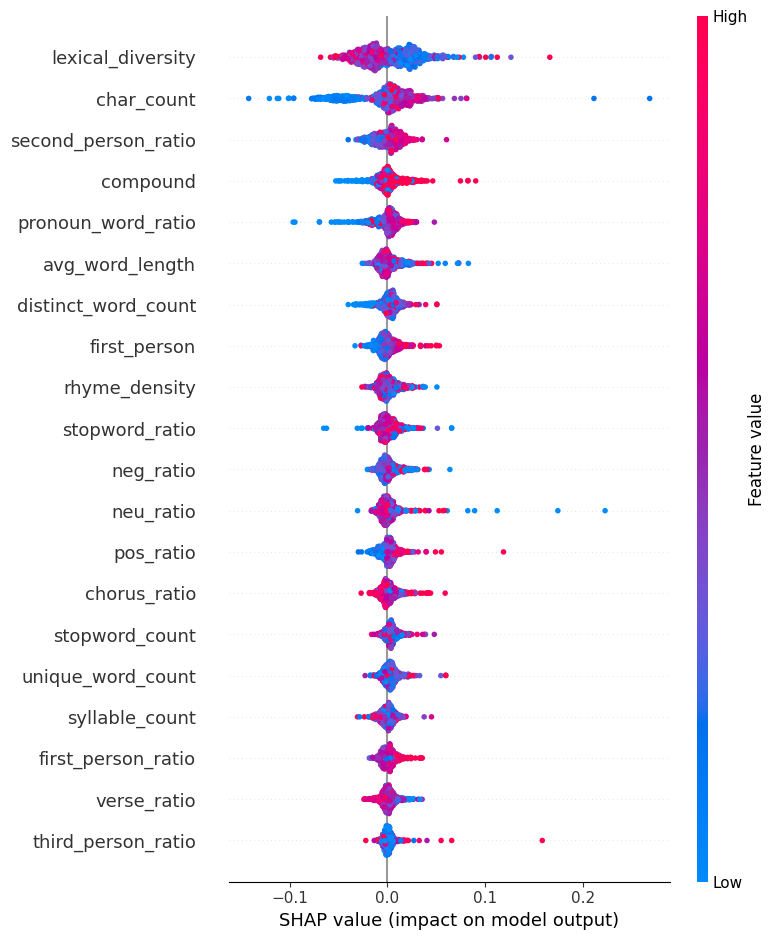

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from math import sqrt
import shap

df_mycs = df_mycs.dropna()

y = df_mycs['MYCS']
X = df_mycs.drop(columns=['MYCS'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
    "Ridge": Ridge(),
    "XGBoost": XGBRegressor(random_state=42),
    "SVR": SVR()
}

print("Model cross-validation scores:")
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print(f"{name}: Mean R² = {scores.mean():.4f}")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_grid, n_iter=10, cv=5, scoring='r2', random_state=42)
search.fit(X_train, y_train)
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("\nBest Model Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

rfe_selector = RFE(estimator=best_model, n_features_to_select=20, step=1)
rfe_selector.fit(X_train, y_train)
rfe_selected = rfe_selector.support_
selected_features = X.columns[rfe_selected]

print("\nTop Features Selected by RFE:")
print(selected_features)

X_train_rfe = X_train[:, rfe_selected]
X_test_rfe = X_test[:, rfe_selected]
best_model.fit(X_train_rfe, y_train)
y_pred_rfe = best_model.predict(X_test_rfe)
rmse_rfe = sqrt(mean_squared_error(y_test, y_pred_rfe))
r2_rfe = r2_score(y_test, y_pred_rfe)
print("\nRFE-Reduced Feature Set Evaluation:")
print(f"RMSE: {rmse_rfe:.4f}")
print(f"R²: {r2_rfe:.4f}")

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test_rfe)

shap.summary_plot(shap_values, features=X_test_rfe, feature_names=selected_features)

shap.initjs()
shap.force_plot(
    shap_values[0].base_values,
    shap_values[0].values,
    features=X_test_rfe[0],
    feature_names=selected_features
)



In [ ]:
pip install shap


In [ ]:
low_importance_threshold = 0.001
low_importance_features = importance_df[importance_df['importance_mean'] < low_importance_threshold]['feature'].tolist()

print(f"\nNumber of low-importance features: {len(low_importance_features)}")
print("Low-importance features:")
print(low_importance_features)

X_reduced = X.drop(columns=low_importance_features)
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(
    scaler.fit_transform(X_reduced), y, test_size=0.2, random_state=42
)

best_model.fit(X_train_red, y_train_red)
y_pred_reduced = best_model.predict(X_test_red)
rmse_reduced = sqrt(mean_squared_error(y_test_red, y_pred_reduced))
r2_reduced = r2_score(y_test_red, y_pred_reduced)

print("\nReduced Feature Set Evaluation:")
print(f"RMSE: {rmse_reduced:.4f}")
print(f"R²: {r2_reduced:.4f}")



Number of low-importance features: 11
Low-importance features:
['section_11', 'verse_count', 'section_6', 'true_repetition_ratio', 'vocab_redundancy_ratio', 'outro_count', 'section_10', 'section_4', 'chorus_count', 'section_9', 'intro_count']

Reduced Feature Set Evaluation:
RMSE: 0.3033
R²: 0.1218


This decrease in performance indicates that eithe these features are necessary or it is the interaction between features that gives it some predictive power


In [ ]:
import shap

explainer = shap.Explainer(best_model)

shap_values = explainer(X_test_red)

shap.summary_plot(shap_values, features=X_test_red, feature_names=selected_features)

shap.initjs()
shap.force_plot(
    shap_values[0].base_values,
    shap_values[0].values,
    features=X_test_rfe[0],
    feature_names=selected_features
)


NameError: name 'best_model' is not defined

In [ ]:
top_features = importance_df['feature'].head(5).tolist()

interaction_feature_names = []
interaction_feature_data = {}

for i in range(len(top_features)):
    for j in range(i + 1, len(top_features)):
        f1, f2 = top_features[i], top_features[j]
        new_col = f"{f1}_x_{f2}"
        X[new_col] = X[f1] * X[f2]
        interaction_feature_names.append(new_col)
        interaction_feature_data[new_col] = X[new_col]

additional_features = pd.DataFrame(interaction_feature_data)

print(f"\nAdded {len(interaction_feature_names)} interaction features:")
print(interaction_feature_names)



Added 10 interaction features:
['char_count_x_lexical_diversity', 'char_count_x_second_person', 'char_count_x_avg_word_length', 'char_count_x_neu_ratio', 'lexical_diversity_x_second_person', 'lexical_diversity_x_avg_word_length', 'lexical_diversity_x_neu_ratio', 'second_person_x_avg_word_length', 'second_person_x_neu_ratio', 'avg_word_length_x_neu_ratio']


In [ ]:
X_inter_scaled = scaler.fit_transform(X)

X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(
    X_inter_scaled, y, test_size=0.2, random_state=42
)

best_model.fit(X_train_int, y_train_int)
y_pred_int = best_model.predict(X_test_int)

rmse_int = sqrt(mean_squared_error(y_test_int, y_pred_int))
r2_int = r2_score(y_test_int, y_pred_int)

print("\nModel Evaluation with Interaction Features:")
print(f"RMSE: {rmse_int:.4f}")
print(f"R²: {r2_int:.4f}")



Model Evaluation with Interaction Features:
RMSE: 0.3028
R²: 0.1248


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_int, y_train_int)

y_pred_rf_int = rf_model.predict(X_test_int)
rmse_rf_int = sqrt(mean_squared_error(y_test_int, y_pred_rf_int))
r2_rf_int = r2_score(y_test_int, y_pred_rf_int)

print("\nRandom Forest with Interaction Features:")
print(f"RMSE: {rmse_rf_int:.4f}")
print(f"R²: {r2_rf_int:.4f}")



Random Forest with Interaction Features:
RMSE: 0.3035
R²: 0.1211


In [ ]:
pip install lightgbm


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_model = lgb.LGBMRegressor(random_state=42)

param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

search = RandomizedSearchCV(lgb_model, param_grid, n_iter=10, cv=5, scoring='r2', random_state=42)
search.fit(X_train, y_train)
best_lgb_model = search.best_estimator_

y_pred = best_lgb_model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("\nLightGBM Model Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8516
[LightGBM] [Info] Number of data points in the train set: 3645, number of used features: 65
[LightGBM] [Info] Start training from score 0.541225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model with adjusted parameters
lgb_model = lgb.LGBMRegressor(
    random_state=42,
    num_leaves=31,  # Lower the number of leaves
    max_depth=10,  # Limit the depth of trees
    learning_rate=0.1,
    n_estimators=100,
    min_child_samples=10,
    min_child_weight=1e-3,
    lambda_l1=1,
    lambda_l2=1
)

param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

search = RandomizedSearchCV(lgb_model, param_grid, n_iter=10, cv=5, scoring='r2', random_state=42)
search.fit(X_train, y_train)
best_lgb_model = search.best_estimator_

y_pred = best_lgb_model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("\nLightGBM Model Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.1 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_model = CatBoostRegressor(random_state=42, verbose=0)

param_grid = {
    'iterations': [100, 200, 300],
    'depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1, 0.2],
    'l2_leaf_reg': [3, 5, 7]
}

search = RandomizedSearchCV(cat_model, param_grid, n_iter=10, cv=5, scoring='r2', random_state=42)
search.fit(X_train, y_train)
best_cat_model = search.best_estimator_

y_pred = best_cat_model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("\nCatBoost Model Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")



CatBoost Model Evaluation:
RMSE: 0.3066
R²: 0.2602


In [ ]:
df_mycs.columns

Index(['MYCS', 'word_count', 'char_count', 'unique_word_count',
       'distinct_word_count', 'avg_word_length', 'stopword_ratio', 'pos_ratio',
       'neg_ratio', 'neu_ratio', 'compound', 'lexical_diversity',
       'syllable_count', 'rhyme_pairs', 'rhyme_density', 'stopword_count',
       'distinct_stopword_count', 'stopword_repetition_ratio',
       'true_repetition_ratio', 'vocab_redundancy_ratio', 'first_person',
       'second_person', 'third_person', 'male_pronouns', 'female_pronouns',
       'total_pronouns', 'pronoun_word_ratio', 'first_person_ratio',
       'second_person_ratio', 'third_person_ratio', 'male_pronoun_ratio',
       'female_pronoun_ratio', 'verse_count', 'intro_count', 'outro_count',
       'bridge_count', 'chorus_count', 'prechorus_count', 'postchorus_count',
       'total_section_count', 'chorus_ratio', 'prechorus_ratio', 'verse_ratio',
       'bridge_ratio', 'section_0', 'section_1', 'section_2', 'section_3',
       'section_4', 'section_5', 'section_6', 'sec

In [ ]:
df_mycs_extended = pd.concat([df_mycs, additional_features], axis=1)

print("Shape of extended DataFrame:", df_mycs_extended.shape)
print("New columns added:", additional_features.columns.tolist())


Shape of extended DataFrame: (4334, 66)
New columns added: ['char_count_x_lexical_diversity', 'char_count_x_second_person', 'char_count_x_avg_word_length', 'char_count_x_neu_ratio', 'lexical_diversity_x_second_person', 'lexical_diversity_x_avg_word_length', 'lexical_diversity_x_neu_ratio', 'second_person_x_avg_word_length', 'second_person_x_neu_ratio', 'avg_word_length_x_neu_ratio']


In [ ]:

df_mycs = pd.read_csv('song_mycs_with_features.csv')
print(df_mycs.head())


                              song         artist                      year  \
0                  Blinding Lights     The Weeknd              [2020, 2021]   
1                    how do i live    leann rimes              [1997, 1998]   
2                             Stay  Justin Bieber              [2021, 2022]   
3                             Stay  The Kid Laroi              [2021, 2022]   
4  All I Want for Christmas Is You   Mariah Carey  [2020, 2021, 2022, 2023]   

            ranking   MYCS                                     lyrics_cleaned  \
0            [1, 3]  2.376  yeah ive been tryna call ive been on my own fo...   
1            [9, 5]  2.256   how do i get through one night without you if...   
2           [12, 3]  2.244  i do the same thing i told you that i never wo...   
3           [12, 3]  2.244  i do the same thing i told you that i never wo...   
4  [67, 78, 65, 55]  2.224  i dont want a lot for christmas there is just ...   

                                      

In [ ]:

df_merged = df_mycs.merge(df_mycs_extended, on=df_mycs.columns.intersection(df_mycs_extended.columns).tolist(), how='left')


print(df_merged.head())


              song         artist          year  ranking   MYCS  \
0  Blinding Lights     The Weeknd  [2020, 2021]   [1, 3]  2.376   
1    how do i live    leann rimes  [1997, 1998]   [9, 5]  2.256   
2             Stay  Justin Bieber  [2021, 2022]  [12, 3]  2.244   
3             Stay  Justin Bieber  [2021, 2022]  [12, 3]  2.244   
4             Stay  The Kid Laroi  [2021, 2022]  [12, 3]  2.244   

                                      lyrics_cleaned  \
0  yeah ive been tryna call ive been on my own fo...   
1   how do i get through one night without you if...   
2  i do the same thing i told you that i never wo...   
3  i do the same thing i told you that i never wo...   
4  i do the same thing i told you that i never wo...   

                                              lyrics  word_count  char_count  \
0  247 ContributorsTranslationsTürkçeSvenskaEspañ...         261        1174   
1                                                NaN         279        1212   
2  166 ContributorsT

In [ ]:

df_merged.to_csv('merged_data.csv', index=False)


In [ ]:
import re
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np

sia = SentimentIntensityAnalyzer()

def compute_chorus_sentiment_shift(lyrics):
    if not isinstance(lyrics, str) or not lyrics.strip():
        return np.nan
    lyrics = re.split(r'\[.*?\]', lyrics, maxsplit=1)[-1]

    sections = re.split(r'(\[.*?\])', lyrics)
    current_section = None
    section_map = {}

    for part in sections:
        if re.match(r'\[.*?\]', part):
            current_section = part.strip()
            if current_section not in section_map:
                section_map[current_section] = ""
        elif current_section:
            section_map[current_section] += part.strip() + " "

    chorus_texts = []
    non_chorus_texts = []

    for sec, text in section_map.items():
        if "chorus" in sec.lower():
            chorus_texts.append(text)
        else:
            non_chorus_texts.append(text)

    def avg_sentiment(texts):
        if not texts:
            return 0
        return sum(sia.polarity_scores(t)['compound'] for t in texts) / len(texts)

    chorus_sent = avg_sentiment(chorus_texts)
    non_chorus_sent = avg_sentiment(non_chorus_texts)

    return chorus_sent - non_chorus_sent


merged_data['chorus_sentiment_shift'] = merged_data['lyrics'].apply(compute_chorus_sentiment_shift)

merged_data[['lyrics', 'chorus_sentiment_shift']].head()



,lyrics,chorus_sentiment_shift
0,247 ContributorsTranslationsTürkçeSvenskaEspañ...,-0.152558
1,NaN,NaN
2,166 ContributorsTranslationsTürkçeEspañolPortu...,0.191633
3,166 ContributorsTranslationsTürkçeEspañolPortu...,0.191633
4,166 ContributorsTranslationsTürkçeEspañolPortu...,0.191633


In [ ]:
from collections import Counter
import numpy as np
import re

def compute_repeated_phrase_intensity(lyrics, n=3):
    if not isinstance(lyrics, str) or not lyrics.strip():
        return np.nan

    cleaned_lyrics = re.sub(r'\[.*?\]', '', lyrics)

    words = re.findall(r'\b\w+\b', cleaned_lyrics.lower())

    ngrams = zip(*[words[i:] for i in range(n)])
    ngram_list = [' '.join(ngram) for ngram in ngrams]

    total = len(ngram_list)
    if total == 0:
        return 0.0

    counts = Counter(ngram_list)
    repeated = sum(1 for phrase, count in counts.items() if count > 1)

    return repeated / total

merged_data['repeated_phrase_intensity'] = merged_data['lyrics'].apply(compute_repeated_phrase_intensity)

merged_data[['lyrics', 'repeated_phrase_intensity']].head()


,lyrics,repeated_phrase_intensity
0,247 ContributorsTranslationsTürkçeSvenskaEspañ...,0.226027
1,NaN,NaN
2,166 ContributorsTranslationsTürkçeEspañolPortu...,0.145125
3,166 ContributorsTranslationsTürkçeEspañolPortu...,0.145125
4,166 ContributorsTranslationsTürkçeEspañolPortu...,0.145125


In [ ]:
from collections import Counter
import numpy as np
import re

def compute_repeated_phrase_intensity(lyrics, n):
    if not isinstance(lyrics, str) or not lyrics.strip():
        return np.nan

    cleaned_lyrics = re.sub(r'\[.*?\]', '', lyrics)

    words = re.findall(r'\b\w+\b', cleaned_lyrics.lower())

    ngrams = zip(*[words[i:] for i in range(n)])
    ngram_list = [' '.join(ngram) for ngram in ngrams]

    total = len(ngram_list)
    if total == 0:
        return 0.0

    counts = Counter(ngram_list)
    repeated = sum(1 for phrase, count in counts.items() if count > 1)

    return repeated / total

merged_data['bigram_repeated_phrase_intensity'] = merged_data['lyrics'].apply(lambda x: compute_repeated_phrase_intensity(x, 2))
merged_data['trigram_repeated_phrase_intensity'] = merged_data['lyrics'].apply(lambda x: compute_repeated_phrase_intensity(x, 3))

merged_data[['bigram_repeated_phrase_intensity', 'trigram_repeated_phrase_intensity']].head()


,bigram_repeated_phrase_intensity,trigram_repeated_phrase_intensity
0,0.228669,0.226027
1,NaN,NaN
2,0.133484,0.145125
3,0.133484,0.145125
4,0.133484,0.145125


In [ ]:
print(merged_data.columns)

Index(['song', 'artist', 'year', 'ranking', 'MYCS', 'lyrics_cleaned', 'lyrics',
       'word_count', 'char_count', 'unique_word_count', 'unique_words',
       'distinct_word_count', 'avg_word_length', 'stopword_ratio', 'pos_ratio',
       'neg_ratio', 'neu_ratio', 'compound', 'lexical_diversity',
       'syllable_count', 'rhyme_pairs', 'rhyme_density', 'stopword_count',
       'distinct_stopword_count', 'stopword_repetition_ratio',
       'true_repetition_ratio', 'vocab_redundancy_ratio', 'first_person',
       'second_person', 'third_person', 'male_pronouns', 'female_pronouns',
       'total_pronouns', 'pronoun_word_ratio', 'first_person_ratio',
       'second_person_ratio', 'third_person_ratio', 'male_pronoun_ratio',
       'female_pronoun_ratio', 'verse_count', 'intro_count', 'outro_count',
       'bridge_count', 'chorus_count', 'prechorus_count', 'postchorus_count',
       'total_section_count', 'chorus_ratio', 'prechorus_ratio', 'verse_ratio',
       'bridge_ratio', 'pattern', 'se

In [ ]:

merged_data.to_csv('final_features.csv', index=False)


In [ ]:
import ast

def has_years_after_1999(years):
    try:
        years_list = ast.literal_eval(years)
        if isinstance(years_list, list):
            return any(y >= 2000 for y in years_list)
    except (ValueError, SyntaxError):
        return False

filtered_data = merged_data[merged_data['year'].apply(has_years_after_1999)].reset_index(drop=True)

print(filtered_data[['year']].head())


           year
0  [2020, 2021]
1  [2021, 2022]
2  [2021, 2022]
3  [2021, 2022]
4  [2021, 2022]


In [ ]:


filtered_data.to_csv('filtered_songs_2000_onward.csv', index=False)
print("Filtered data saved to 'filtered_songs_2000_onward.csv'")


Filtered data saved to 'filtered_songs_2000_onward.csv'


In [ ]:

import pandas as pd
import ast

try:
    filtered_data_songs_2000_onward = pd.read_csv('filtered_songs_2000_onward.csv')
except FileNotFoundError:
    print("Error: 'filtered_songs_2000_onward.csv' not found. Please ensure the file exists.")
    filtered_data_songs_2000_onward = pd.DataFrame()

print(filtered_data_songs_2000_onward.head())


              song         artist          year  ranking   MYCS  \
0  Blinding Lights     The Weeknd  [2020, 2021]   [1, 3]  2.376   
1             Stay  Justin Bieber  [2021, 2022]  [12, 3]  2.244   
2             Stay  Justin Bieber  [2021, 2022]  [12, 3]  2.244   
3             Stay  The Kid Laroi  [2021, 2022]  [12, 3]  2.244   
4             Stay  The Kid Laroi  [2021, 2022]  [12, 3]  2.244   

                                      lyrics_cleaned  \
0  yeah ive been tryna call ive been on my own fo...   
1  i do the same thing i told you that i never wo...   
2  i do the same thing i told you that i never wo...   
3  i do the same thing i told you that i never wo...   
4  i do the same thing i told you that i never wo...   

                                              lyrics  word_count  char_count  \
0  247 ContributorsTranslationsTürkçeSvenskaEspañ...         261        1174   
1  166 ContributorsTranslationsTürkçeEspañolPortu...         423        1790   
2  166 ContributorsT

In [ ]:

print(filtered_data_songs_2000_onward['MYCS'].std())

0.38996344063458066


In [ ]:
nan_lyrics_before = filtered_data_songs_2000_onward['lyrics'].isna().sum()

filtered_data_songs_2000_onward = filtered_data_songs_2000_onward.dropna(subset=['lyrics'])

nan_lyrics_after = filtered_data_songs_2000_onward['lyrics'].isna().sum()

dropped_count = nan_lyrics_before - nan_lyrics_after

print(f"Number of records dropped due to NaN lyrics: {dropped_count}")


Number of records dropped due to NaN lyrics: 48


In [ ]:

import pandas as pd

try:
    filtered_data = pd.read_csv('filtered_songs_2000_onward.csv')
except FileNotFoundError:
    print("Error: 'filtered_songs_2000_onward.csv' not found. Please ensure the file exists.")
    filtered_data = pd.DataFrame()

filtered_data = filtered_data.drop(columns=['song', 'artist', 'lyrics', 'pattern', 'lyrics_cleaned', 'unique_words', 'year','ranking'])

if 'MYCS' in filtered_data.columns:
    X = filtered_data.drop(columns=['MYCS'])
    y = filtered_data['MYCS']
else:
    print("Error: 'MYCS' column not found in the DataFrame.")
    X = None
    y = None


In [ ]:
print(filtered_data.columns)

Index(['MYCS', 'word_count', 'char_count', 'unique_word_count',
       'distinct_word_count', 'avg_word_length', 'stopword_ratio', 'pos_ratio',
       'neg_ratio', 'neu_ratio', 'compound', 'lexical_diversity',
       'syllable_count', 'rhyme_pairs', 'rhyme_density', 'stopword_count',
       'distinct_stopword_count', 'stopword_repetition_ratio',
       'true_repetition_ratio', 'vocab_redundancy_ratio', 'first_person',
       'second_person', 'third_person', 'male_pronouns', 'female_pronouns',
       'total_pronouns', 'pronoun_word_ratio', 'first_person_ratio',
       'second_person_ratio', 'third_person_ratio', 'male_pronoun_ratio',
       'female_pronoun_ratio', 'verse_count', 'intro_count', 'outro_count',
       'bridge_count', 'chorus_count', 'prechorus_count', 'postchorus_count',
       'total_section_count', 'chorus_ratio', 'prechorus_ratio', 'verse_ratio',
       'bridge_ratio', 'section_0', 'section_1', 'section_2', 'section_3',
       'section_4', 'section_5', 'section_6', 'sec

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score

print("Loading and preparing data...")
try:
    filtered_data = pd.read_csv('filtered_songs_2000_onward.csv')
    print(f"Successfully loaded 'filtered_songs_2000_onward.csv'. Shape: {filtered_data.shape}")
    columns_to_drop = ['song', 'artist', 'lyrics', 'pattern', 'lyrics_cleaned', 'unique_words', 'year', 'ranking']
    existing_columns_to_drop = [col for col in columns_to_drop if col in filtered_data.columns]
    if len(existing_columns_to_drop) > 0:
         print(f"Dropping columns: {existing_columns_to_drop}")
         filtered_data = filtered_data.drop(columns=existing_columns_to_drop)
    else:
         print("No specified columns to drop were found.")

    if 'MYCS' in filtered_data.columns:
        initial_rows = len(filtered_data)
        filtered_data = filtered_data.dropna(subset=['MYCS'])
        rows_after_dropna = len(filtered_data)
        if initial_rows > rows_after_dropna:
            print(f"Dropped {initial_rows - rows_after_dropna} rows with missing 'MYCS' values.")
    else:
         raise ValueError("'MYCS' column not found after loading and initial drop. Cannot proceed.")

    X = filtered_data.drop(columns=['MYCS'])
    y = filtered_data['MYCS']
    print(f"Features (X) shape: {X.shape}")
    print(f"Target (y) shape: {y.shape}")
    print("Data preparation complete.")
    print("-" * 30)
except FileNotFoundError:
    print("Error: 'filtered_songs_2000_onward.csv' not found. Please ensure the file exists in the correct directory.")
    X = None; y = None
except ValueError as ve:
     print(f"Error during data preparation: {ve}")
     X = None; y = None
except Exception as e:
    print(f"An unexpected error occurred during data loading/preparation: {e}")
    X = None; y = None


if X is not None and y is not None:
    print("Splitting data into training and test sets (80/20 split)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
    print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")
    print("-" * 30)

    print("Checking for NaN values in training data (first 10 columns with NaNs):")
    nan_counts = X_train.isnull().sum()
    print(nan_counts[nan_counts > 0].sort_values(ascending=False).head(10))
    print("-" * 30)


    print("Defining models with imputation...")

    imputer_strategy = 'median'

    models = {
        "Linear Regression": Pipeline([
            ('imputer', SimpleImputer(strategy=imputer_strategy)),
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ]),
        "Ridge Regression": Pipeline([
            ('imputer', SimpleImputer(strategy=imputer_strategy)),
            ('scaler', StandardScaler()),
            ('regressor', Ridge(random_state=42))
        ]),
        "Lasso Regression": Pipeline([
            ('imputer', SimpleImputer(strategy=imputer_strategy)),
            ('scaler', StandardScaler()),
            ('regressor', Lasso(random_state=42))
        ]),
        "Random Forest": Pipeline([
            ('imputer', SimpleImputer(strategy=imputer_strategy)),
            ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
        ]),
        "Gradient Boosting (Hist)": Pipeline([

            ('regressor', HistGradientBoostingRegressor(random_state=42))
        ]),
        "Support Vector Regressor (SVR)": Pipeline([
            ('imputer', SimpleImputer(strategy=imputer_strategy)),
            ('scaler', StandardScaler()),
            ('regressor', SVR())
        ]),
        "K-Neighbors Regressor (KNN)": Pipeline([
            ('imputer', SimpleImputer(strategy=imputer_strategy)),
            ('scaler', StandardScaler()),
            ('regressor', KNeighborsRegressor())
        ])
    }


    print(f"Defined models with imputation: {list(models.keys())}")
    print("-" * 30)

    print("Training and evaluating models...")
    results = {}

    for name, model_pipeline in models.items():
        print(f"--- Training {name} ---")
        try:
            model_pipeline.fit(X_train, y_train)

            y_pred = model_pipeline.predict(X_test)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            results[name] = {'RMSE': rmse, 'R2': r2}
            print(f"    RMSE: {rmse:.4f}")
            print(f"    R²:   {r2:.4f}")

        except Exception as e:
            print(f"    ERROR training/evaluating {name}: {e}")
            results[name] = {'RMSE': None, 'R2': None}

    print("-" * 30)
    print("Model training and evaluation complete.")
    print("-" * 30)

    print("Performance Summary:")
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values(by='R2', ascending=False)
    print(results_df.to_string(formatters={'RMSE': '{:.4f}'.format, 'R2': '{:.4f}'.format}))

else:
    print("\nSkipping model training due to errors in data loading or preparation.")

Loading and preparing data...
Successfully loaded 'filtered_songs_2000_onward.csv'. Shape: (3124, 78)
Dropping columns: ['song', 'artist', 'lyrics', 'pattern', 'lyrics_cleaned', 'unique_words', 'year', 'ranking']
Features (X) shape: (3124, 69)
Target (y) shape: (3124,)
Data preparation complete.
------------------------------
Splitting data into training and test sets (80/20 split)...
Training set shape: X_train=(2499, 69), y_train=(2499,)
Test set shape: X_test=(625, 69), y_test=(625,)
------------------------------
Checking for NaN values in training data (first 10 columns with NaNs):
char_count_x_second_person             376
char_count_x_lexical_diversity         376
char_count_x_neu_ratio                 376
char_count_x_avg_word_length           376
lexical_diversity_x_second_person      376
lexical_diversity_x_avg_word_length    376
second_person_x_avg_word_length        376
lexical_diversity_x_neu_ratio          376
second_person_x_neu_ratio              376
avg_word_length_x_n

 best model's RMSE ~0.3001 is indeed significantly lower than the standard deviation 0.3904. This confirms that your model has learned meaningful patterns and makes predictions that are substantially better than just guessing the average. It reduces the typical error by about 23% compared to that baseline.

In [ ]:

import pandas as pd
import numpy as np

try:
    filtered_data = pd.read_csv('filtered_songs_2000_onward.csv')
except FileNotFoundError:
    print("Error: 'filtered_songs_2000_onward.csv' not found. Please make sure the file exists.")
    exit()

print(filtered_data['MYCS'].std())


0.390402373479723


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

from sklearn.metrics import mean_squared_error, r2_score
import time # To time the search


print("Loading and preparing data (ensure previous steps were run)...")
try:

    filtered_data = pd.read_csv('filtered_songs_2000_onward.csv')
    columns_to_drop = ['song', 'artist', 'lyrics', 'pattern', 'lyrics_cleaned', 'unique_words', 'year', 'ranking']
    existing_columns_to_drop = [col for col in columns_to_drop if col in filtered_data.columns]
    filtered_data = filtered_data.drop(columns=existing_columns_to_drop)
    if 'MYCS' in filtered_data.columns:
        filtered_data = filtered_data.dropna(subset=['MYCS'])
        X = filtered_data.drop(columns=['MYCS'])
        y = filtered_data['MYCS']
        print(f"Data loaded successfully. X shape: {X.shape}, y shape: {y.shape}")
        print("-" * 30)
    else:
        raise ValueError("'MYCS' column not found.")

except Exception as e:
    print(f"Error loading/preparing data: {e}. Cannot proceed.")
    X = None; y = None

if X is not None and y is not None:


    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print("Data splitting complete.")
    print("-" * 30)


    pipeline_rf = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
    ])

    param_dist_rf = {
        'regressor__n_estimators': [100, 200, 300, 400, 500],
        'regressor__max_depth': [10, 20, 30, None],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 3, 5],
        'regressor__max_features': ['sqrt', 'log2', 0.3, 0.5]
    }


    pipeline_hgbr = HistGradientBoostingRegressor(random_state=42)

    param_dist_hgbr = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_iter': [100, 200, 300, 500],
        'max_leaf_nodes': [15, 31, 63],
        'max_depth': [3, 5, 10, None],
        'min_samples_leaf': [10, 20, 30, 50],
        'l2_regularization': [0.0, 0.01, 0.1, 1.0] # L2 penalty
    }



    n_iter_search = 50
    cv_folds = 5
    scoring_metric = 'neg_root_mean_squared_error'

    print(f"Setting up RandomizedSearchCV (n_iter={n_iter_search}, cv={cv_folds})...")

    print("\n--- Starting Random Forest Tuning ---")
    start_time_rf = time.time()
    random_search_rf = RandomizedSearchCV(
        estimator=pipeline_rf,
        param_distributions=param_dist_rf,
        n_iter=n_iter_search,
        cv=cv_folds,
        scoring=scoring_metric,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    random_search_rf.fit(X_train, y_train)
    end_time_rf = time.time()
    print(f"--- Random Forest Tuning Finished ({end_time_rf - start_time_rf:.2f} seconds) ---")
    print(f"Best RF Score (CV neg_RMSE): {random_search_rf.best_score_:.4f}")
    print("Best RF Parameters:")
    print(random_search_rf.best_params_)
    print("-" * 30)


    print("\n--- Starting Gradient Boosting (Hist) Tuning ---")
    start_time_hgbr = time.time()
    random_search_hgbr = RandomizedSearchCV(
        estimator=pipeline_hgbr,
        param_distributions=param_dist_hgbr,
        n_iter=n_iter_search,
        cv=cv_folds,
        scoring=scoring_metric,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    random_search_hgbr.fit(X_train, y_train)
    end_time_hgbr = time.time()
    print(f"--- Gradient Boosting Tuning Finished ({end_time_hgbr - start_time_hgbr:.2f} seconds) ---")
    print(f"Best HGBR Score (CV neg_RMSE): {random_search_hgbr.best_score_:.4f}")
    print("Best HGBR Parameters:")
    print(random_search_hgbr.best_params_)
    print("-" * 30)

    print("\n--- Evaluating Best Models Found on Test Set ---")

    best_rf = random_search_rf.best_estimator_
    y_pred_rf_tuned = best_rf.predict(X_test)
    rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
    r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)
    print("\nTuned Random Forest Performance:")
    print(f"  RMSE: {rmse_rf_tuned:.4f}")
    print(f"  R²:   {r2_rf_tuned:.4f}")

    best_hgbr = random_search_hgbr.best_estimator_
    y_pred_hgbr_tuned = best_hgbr.predict(X_test)
    rmse_hgbr_tuned = np.sqrt(mean_squared_error(y_test, y_pred_hgbr_tuned))
    r2_hgbr_tuned = r2_score(y_test, y_pred_hgbr_tuned)
    print("\nTuned Gradient Boosting (Hist) Performance:")
    print(f"  RMSE: {rmse_hgbr_tuned:.4f}")
    print(f"  R²:   {r2_hgbr_tuned:.4f}")

    print("-" * 30)
    print("Hyperparameter tuning evaluation complete.")

else:
    print("\nSkipping hyperparameter tuning due to errors in data loading or preparation.")

Loading and preparing data (ensure previous steps were run)...
Data loaded successfully. X shape: (3124, 69), y shape: (3124,)
------------------------------
Splitting data...
Data splitting complete.
------------------------------
Setting up RandomizedSearchCV (n_iter=50, cv=5)...

--- Starting Random Forest Tuning ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--- Random Forest Tuning Finished (891.98 seconds) ---
Best RF Score (CV neg_RMSE): -0.2726
Best RF Parameters:
{'regressor__n_estimators': 400, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 30}
------------------------------

--- Starting Gradient Boosting (Hist) Tuning ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--- Gradient Boosting Tuning Finished (296.20 seconds) ---
Best HGBR Score (CV neg_RMSE): -0.2805
Best HGBR Parameters:
{'min_samples_leaf': 10, 'max_leaf_nodes': 15, 'max_iter': 200, 'max_depth':

In [ ]:
filtered_data.head()

,MYCS,word_count,char_count,unique_word_count,distinct_word_count,avg_word_length,stopword_ratio,pos_ratio,neg_ratio,neu_ratio,...,lexical_diversity_x_second_person,lexical_diversity_x_avg_word_length,lexical_diversity_x_neu_ratio,second_person_x_avg_word_length,second_person_x_neu_ratio,avg_word_length_x_neu_ratio,chorus_sentiment_shift,repeated_phrase_intensity,bigram_repeated_phrase_intensity,trigram_repeated_phrase_intensity
0,2.376,261,1174,43,96,3.501916,0.43,0.077,0.094,0.829,...,1.812261,0.576944,0.136579,38.521073,9.119,2.903088,-0.152558,0.226027,0.228669,0.226027
1,2.244,423,1790,42,88,3.234043,0.47,0.071,0.095,0.834,...,3.872340,0.321111,0.082809,126.127660,32.526,2.697191,0.191633,0.145125,0.133484,0.145125
2,2.244,423,1790,42,88,3.234043,0.47,0.071,0.095,0.834,...,3.872340,0.321111,0.082809,126.127660,32.526,2.697191,0.191633,0.145125,0.133484,0.145125
3,2.244,423,1790,42,88,3.234043,0.47,0.071,0.095,0.834,...,3.872340,0.321111,0.082809,126.127660,32.526,2.697191,0.191633,0.145125,0.133484,0.145125
4,2.244,423,1790,42,88,3.234043,0.47,0.071,0.095,0.834,...,3.872340,0.321111,0.082809,126.127660,32.526,2.697191,0.191633,0.145125,0.133484,0.145125


In [ ]:
import pandas as pd
import numpy as np

input_filename = 'filtered_songs_2000_onward.csv'
output_filename = 'cleaned_deduplicated_songs.csv'
deduplication_columns = ['song', 'year']
target_column = 'MYCS'
columns_to_drop_after_processing = [
    'song', 'artist', 'lyrics', 'pattern',
    'lyrics_cleaned', 'unique_words', 'year', 'ranking'
]

print(f"Starting data cleaning process for '{input_filename}'...")

try:
    print(f"Loading data from '{input_filename}'...")
    df = pd.read_csv(input_filename)
    print(f"Successfully loaded. Initial shape: {df.shape}")
    print("-" * 30)

    print("Step 2: Removing duplicates...")
    if all(col in df.columns for col in deduplication_columns):
        initial_rows_dedup = len(df)
        df = df.drop_duplicates(subset=deduplication_columns, keep='first')
        rows_after_dedup = len(df)
        print(f"Shape after deduplication on {deduplication_columns}: {df.shape}")
        if initial_rows_dedup > rows_after_dedup:
             print(f"Removed {initial_rows_dedup - rows_after_dedup} duplicate entries.")
        else:
             print("No duplicate entries found based on specified columns.")
    else:
        print(f"Warning: One or more columns {deduplication_columns} not found. Skipping deduplication.")
    print("-" * 30)

    print(f"Step 3: Removing rows with missing target ('{target_column}')...")
    if target_column in df.columns:
        initial_rows_dropna = len(df)
        df = df.dropna(subset=[target_column])
        rows_after_dropna = len(df)
        print(f"Shape after dropping rows with missing '{target_column}': {df.shape}")
        if initial_rows_dropna > rows_after_dropna:
            print(f"Removed {initial_rows_dropna - rows_after_dropna} rows.")
        else:
            print(f"No rows removed due to missing '{target_column}'.")
    else:
        print(f"Warning: Target column '{target_column}' not found. Skipping removal of rows with missing target.")
    print("-" * 30)

    print("Step 4: Dropping specified unnecessary columns...")
    existing_columns_to_drop = [col for col in columns_to_drop_after_processing if col in df.columns]
    if len(existing_columns_to_drop) > 0:
         print(f"Dropping columns: {existing_columns_to_drop}")
         df = df.drop(columns=existing_columns_to_drop)
         print(f"Shape after dropping columns: {df.shape}")
    else:
         print("No specified columns found to drop.")
    print("-" * 30)

    print(f"Step 5: Saving cleaned data to '{output_filename}'...")
    df.to_csv(output_filename, index=False)
    print(f"Successfully saved cleaned data with final shape {df.shape} to '{output_filename}'.")
    print("-" * 30)

    print("Data cleaning process finished.")

except FileNotFoundError:
    print(f"Error: Input file '{input_filename}' not found. Please ensure the file exists.")
except Exception as e:
    print(f"An unexpected error occurred during the cleaning process: {e}")

In [ ]:
import pandas as pd
import numpy as np

input_filename = 'final_features.csv'
output_filename = 'cleaned_deduplicated_songs_v2.csv'
deduplication_columns = ['song', 'year', 'ranking']
target_column = 'MYCS'

print(f"Starting data cleaning process for '{input_filename}'...")

try:
    print(f"Loading data from '{input_filename}'...")
    df = pd.read_csv(input_filename)
    print(f"Successfully loaded. Initial shape: {df.shape}")
    print("-" * 30)

    print("Step 2: Removing duplicates based on 'song', 'year', and 'ranking'...")
    if all(col in df.columns for col in deduplication_columns):
        initial_rows_dedup = len(df)
        df = df.drop_duplicates(subset=deduplication_columns, keep='first')
        rows_after_dedup = len(df)
        print(f"Shape after deduplication on {deduplication_columns}: {df.shape}")
        if initial_rows_dedup > rows_after_dedup:
             print(f"Removed {initial_rows_dedup - rows_after_dedup} duplicate {deduplication_columns} entries.")
        else:
             print(f"No duplicate entries found based on {deduplication_columns}.")
    else:
        missing_cols = [col for col in deduplication_columns if col not in df.columns]
        print(f"Warning: One or more columns needed for deduplication ({missing_cols}) not found. Skipping deduplication.")
    print("-" * 30)

    print(f"Step 3: Removing rows with missing target ('{target_column}')...")
    if target_column in df.columns:
        initial_rows_dropna = len(df)
        df = df.dropna(subset=[target_column])
        rows_after_dropna = len(df)
        print(f"Shape after dropping rows with missing '{target_column}': {df.shape}")
        if initial_rows_dropna > rows_after_dropna:
            print(f"Removed {initial_rows_dropna - rows_after_dropna} rows.")
        else:
            print(f"No rows removed due to missing '{target_column}'.")
    else:
        print(f"Warning: Target column '{target_column}' not found. Skipping removal of rows with missing target.")
    print("-" * 30)


    print(f"Step 4: Saving cleaned and deduplicated data to '{output_filename}'...")
    df.to_csv(output_filename, index=False)
    print(f"Successfully saved cleaned data with final shape {df.shape} to '{output_filename}'.")
    print("All original columns (except those used for deduplication if dropped earlier by mistake, but now kept) and target column are preserved.")
    print("-" * 30)

    print("Data cleaning process finished.")

except FileNotFoundError:
    print(f"Error: Input file '{input_filename}' not found. Please ensure the file exists.")
except Exception as e:
    print(f"An unexpected error occurred during the cleaning process: {e}")

Starting data cleaning process for 'final_features.csv'...
Loading data from 'final_features.csv'...
Successfully loaded. Initial shape: (6555, 78)
------------------------------
Step 2: Removing duplicates based on 'song', 'year', and 'ranking'...
Shape after deduplication on ['song', 'year', 'ranking']: (5618, 78)
Removed 937 duplicate ['song', 'year', 'ranking'] entries.
------------------------------
Step 3: Removing rows with missing target ('MYCS')...
Shape after dropping rows with missing 'MYCS': (5618, 78)
No rows removed due to missing 'MYCS'.
------------------------------
Step 4: Saving cleaned and deduplicated data to 'cleaned_deduplicated_songs_v2.csv'...
Successfully saved cleaned data with final shape (5618, 78) to 'cleaned_deduplicated_songs_v2.csv'.
All original columns (except those used for deduplication if dropped earlier by mistake, but now kept) and target column are preserved.
------------------------------
Data cleaning process finished.


In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

df_mycs = pd.read_csv('cleaned_deduplicated_songs_v2.csv')




In [ ]:
import pandas as pd

df_mycs = pd.read_csv('cleaned_deduplicated_songs_v2.csv')

cols_to_drop = [
    'char_count_x_lexical_diversity',
    'char_count_x_second_person',
    'char_count_x_avg_word_length',
    'char_count_x_neu_ratio',
    'lexical_diversity_x_second_person',
    'lexical_diversity_x_avg_word_length',
    'lexical_diversity_x_neu_ratio',
    'second_person_x_avg_word_length',
    'second_person_x_neu_ratio',
    'avg_word_length_x_neu_ratio'
]

df_mycs.drop(columns=[col for col in cols_to_drop if col in df_mycs.columns], inplace=True)

print(df_mycs.columns)


Index(['song', 'artist', 'year', 'ranking', 'MYCS', 'lyrics_cleaned', 'lyrics',
       'word_count', 'char_count', 'unique_word_count', 'unique_words',
       'distinct_word_count', 'avg_word_length', 'stopword_ratio', 'pos_ratio',
       'neg_ratio', 'neu_ratio', 'compound', 'lexical_diversity',
       'syllable_count', 'rhyme_pairs', 'rhyme_density', 'stopword_count',
       'distinct_stopword_count', 'stopword_repetition_ratio',
       'true_repetition_ratio', 'vocab_redundancy_ratio', 'first_person',
       'second_person', 'third_person', 'male_pronouns', 'female_pronouns',
       'total_pronouns', 'pronoun_word_ratio', 'first_person_ratio',
       'second_person_ratio', 'third_person_ratio', 'male_pronoun_ratio',
       'female_pronoun_ratio', 'verse_count', 'intro_count', 'outro_count',
       'bridge_count', 'chorus_count', 'prechorus_count', 'postchorus_count',
       'total_section_count', 'chorus_ratio', 'prechorus_ratio', 'verse_ratio',
       'bridge_ratio', 'pattern', 'se

In [ ]:
df_mycs.to_csv('final_clean_to_do_interaction_features.csv', index=False)

print("Saved cleaned data to 'final_clean_to_do_interaction_features.csv'.")

Saved cleaned data to 'final_clean_to_do_interaction_features.csv'.
